In [207]:
import gensim
import os
import csv
import nltk
import numpy as np

from scipy.spatial.distance import cosine as cosine_distance

from matplotlib import pyplot as plt
%matplotlib inline

In [48]:
porter = nltk.PorterStemmer()

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

stopw = set(stopwords.words('english'))

def clean_token(w):
    w = porter.stem(''.join([a.lower() for a in w if a.isalnum()]))
    return w
    
def clean_phrase(s):
    s = s.split()
    s = ' '.join([clean_token(w) for w in s])
    return s

def remove_stopw(s):
    s = clean_phrase(s)
    s = ' '.join([i for i in wordpunct_tokenize(s) if i not in stopw])
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rafael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [209]:
w2v = gensim.models.Word2Vec.load_word2vec_format('cases_w2v.bin', binary=True)

def similarity(ta, tb):
    # Some terms are not in the w2v model, check first.
    if (ta in w2v.vocab) and (tb in w2v.vocab):
        return w2v.similarity(ta, tb)
    else:
        return 0

In [294]:
with open('inputData.csv', 'r') as infile:
    reader = csv.reader(infile)
    data = [row for row in reader]

with open('outputData.csv', 'r') as testfile:
    reader = csv.reader(testfile)
    test = [row for row in reader]

#subset = (0,30)
subset = None
if subset is not None:
    questions_original = [d[0] for d in data][subset[0]:subset[1]]
    answers_original = [d[1:] for d in data][subset[0]:subset[1]]
    validation_original = [t[1] for t in test][subset[0]:subset[1]]

    questions = [remove_stopw(d[0]) for d in data][subset[0]:subset[1]]
    answers = [map(remove_stopw, d[1:]) for d in data][subset[0]:subset[1]]
    validation = [remove_stopw(t[1]) for t in test][subset[0]:subset[1]]
else:
    questions_original = [d[0] for d in data]
    answers_original = [d[1:] for d in data]
    validation_original = [t[1] for t in test]

    questions = [remove_stopw(d[0]) for d in data]
    answers = [map(remove_stopw, d[1:]) for d in data]
    validation = [remove_stopw(t[1]) for t in test]

# Build a numeric answer table
validation_indices = [-1]*len(validation)
for i, va in enumerate(zip(validation, answers)):
    v, ans = va
    for j, a in enumerate(ans):
        if v == a:
            validation_indices[i] = j
            break
            
# Check if an answer wasnt found
assert len([i for i, e in enumerate([v >= 0 for v in validation_indices]) if e == False]) == 0

In [297]:
# Function to validate a set of answers
def precision(model):
    scores = model_scores(model)
    guesses = map(lambda x: x.index(max(x)), scores)
    marks = [float(g == v) for g, v in zip(guesses, validation_indices)]
    return sum(marks)/len(validation_indices)

# Scores for a given model
def model_scores(model, qapair=None):
    if qapair is None:  # Do all
        scores = [[]]*len(questions)
        for i in xrange(len(questions)):
            scores[i] = model(questions[i], answers[i])
    else:
        scores = model(questions[qapair], answers[qapair])
    return scores

# Print scores for a QA index
def print_qapair_scores(model, qapair=0):
    scores = model_scores(model, qapair)
    print "Question:"
    qs = "\t"+questions_original[qapair][:50]
    if len(qs) < len(questions_original[qapair]): qs += "..."
    print qs
    print "Answers and scores:"
    for i, e in enumerate(scores):
        correct = (i == validation_indices[qapair])
        guessed = (e == max(scores))
        anss = ''
        if correct:
            anss += " *"
        if guessed:
            anss += " +"
        #if not (correct or guessed):
        anss += "\t"+"Score %02.2f\t" % (e)
        anss += answers_original[qapair][i][:30]
        anss += "... [%d stems]" % len(answers[qapair][i].split()) 
        print anss

def plot_word_scores(model, qaa_pair):
    scores = model(questions[qaa_pair[0]], [answers[qaa_pair[0]][qaa_pair[1]]], True)
    scores = sorted(scores)
    plt.plot(scores)
    plt.ylabel("Total word score")
    plt.xlabel("Word rank")
    # return scores

In [233]:
# First model: Choose the answer with the greatest number
# of common words with the question
def equal_words(question, candidates):
    """
    Check the number of words in answers contained in question
    """
    qtokens = list(set(question.split()))
    counts = [0]*len(candidates)
    for i, c in enumerate(candidates):
        candidate = c.split()
        counts[i] = len([token for token in candidate if token in qtokens])
    return counts

print_qapair_scores(equal_words, 7)
precision(equal_words)

Question:
	Can a non-filed claim be used in connection with a...
Answers and scores:
	Score 10.00	Here, the Court cannot determi... [83 stems]
 *	Score 1.00	(a) A claim or interest, proof... [25 stems]
 +	Score 43.00	--------- Notes: [1] The movan... [939 stems]
	Score 11.00	(18) The "production system" c... [156 stems]
	Score 10.00	The " second connecting device... [172 stems]


0.06666666666666667

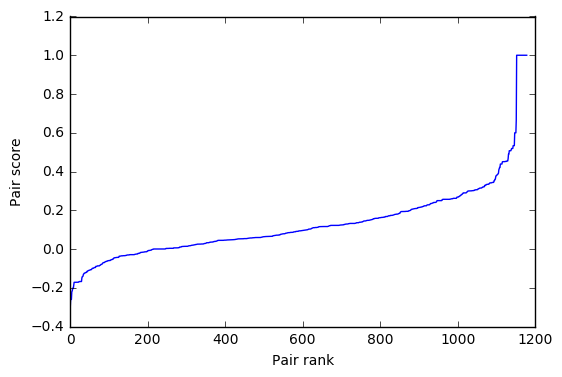

In [289]:
# Second model: Use Word2Vec and use pairwise token similarity score
def pairwise_similarity(question, candidates, get_sim=False):
    qtokens = list(set(question.split()))
    scores = [0]*len(candidates)
    for i, c in enumerate(candidates):
        candidate = c.split()
        similarities = [similarity(qt, ct) for qt in qtokens for ct in candidate]
        scores[i] = sum(similarities)
        # Normalize score according to sentence length and discounted pairs
        scores[i] /= (len(qtokens)*len(candidate)) - len([s for s in similarities if s == 0])
    if get_sim:
        return similarities
    else:
        return scores

#print_qapair_scores(pairwise_similarity, 7)
plot_word_scores(pairwise_similarity, (22, 0))
# precision(pairwise_similarity)

Question:
	Can an insider purchase the debt of a bankrupt com...
Answers and scores:
	Score 0.07	S. 625 responds to the bankrup... [80 stems]
	Score 0.07	There is a related, and more n... [239 stems]
	Score 0.04	--------- Notes: [1] Rule 2002... [2122 stems]
 * +	Score 0.07	The Bankruptcy Court held that... [239 stems]
	Score 0.06	--------- Notes: [1] Fait, Inc... [243 stems]


0.5

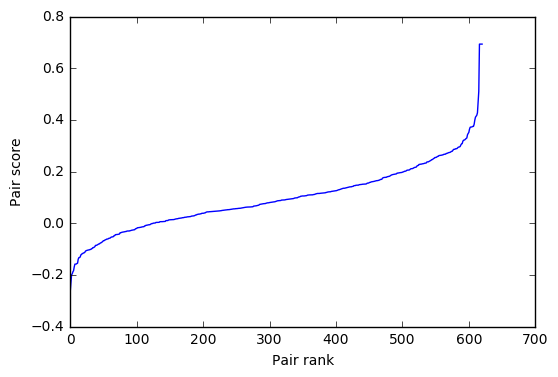

In [285]:
# Third model: Smooth Word2Vec similarities
def pairwise_similarity_log(question, candidates, get_sim=False):
    qtokens = list(set(question.split()))
    scores = [0]*len(candidates)
    for i, c in enumerate(candidates):
        candidate = c.split()
        words = {}
        [words.update([(qt+ct, similarity(qt, ct))]) for qt in qtokens for ct in candidate]
        similarities = words.values()
        scores_pos = [np.log(k+1) for k in similarities if k > 0]
        scores_neg = [-np.log(-k+1) for k in similarities if k < 0]
        similarities = scores_neg+scores_pos
        scores[i] = (sum(scores_pos)-sum(scores_neg))/((len(qtokens)*len(candidate)) - len([s for s in similarities if s == 0]))
    if get_sim:
        return similarities
    else:
        return scores

print_qapair_scores(pairwise_similarity_log, 6)
plot_word_scores(pairwise_similarity_log, (22, 0))
precision(pairwise_similarity)

Question:
	Can an insider purchase the debt of a bankrupt com...
Answers and scores:
 +	Score 0.03	S. 625 responds to the bankrup... [80 stems]
	Score 0.01	There is a related, and more n... [239 stems]
	Score 0.00	--------- Notes: [1] Rule 2002... [2122 stems]
 *	Score 0.01	The Bankruptcy Court held that... [239 stems]
	Score 0.01	--------- Notes: [1] Fait, Inc... [243 stems]


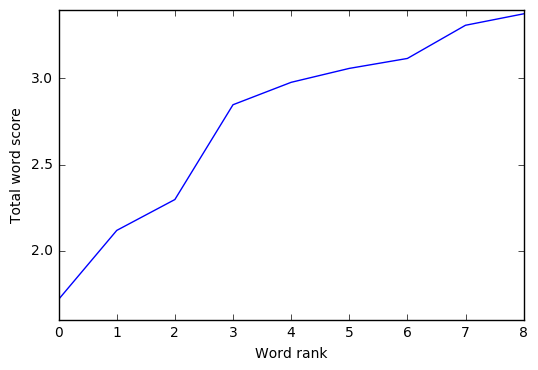

In [299]:
# Fourth model: Question words fraction
def similarity_log_completion(question, candidates, get_sim=False):
    qtokens = list(set(question.split()))
    scores = [0]*len(candidates)
    for i, c in enumerate(candidates):
        candidate = c.split()
        words = {}
        [words.update([(qt, words.setdefault(qt,0)+similarity(qt, ct))]) for qt in qtokens for ct in candidate]
        similarities = words.values()
        scores_pos = [np.log(k+1) for k in similarities if k > 0]
        scores_neg = [-np.log(-k+1) for k in similarities if k < 0]
        similarities = scores_neg+scores_pos
        scores[i] = (sum(scores_pos)-sum(scores_neg))/((len(qtokens)*len(candidate)) - len([s for s in similarities if s == 0]))
    if get_sim:
        return similarities
    else:
        return scores

print_qapair_scores(similarity_log_completion, 6)
plot_word_scores(similarity_log_completion, (22, 0))
# precision(similarity_log_completion)

In [295]:
print "Equal Words..."
#p_equal_words = precision(equal_words)
print "Similarity..."
#p_pairwise_similarity = precision(pairwise_similarity)
print "Similarity Log..."
#p_pairwise_similarity_log = precision(pairwise_similarity_log)
print "Log Completion..."
p_similarity_log_completion = precision(similarity_log_completion)

Equal Words...
Similarity...
Similarity Log...
Log Completion...


In [296]:
print "Equal Words:\t\t\t %0.2f" % p_equal_words
print "Pairwise Similarity:\t\t %0.2f" % p_pairwise_similarity
print "Pairwise Similarity Log:\t %0.2f" % p_pairwise_similarity_log
print "Similarity Log Completion:\t %0.2f" % p_similarity_log_completion

Equal Words:			 0.06
Pairwise Similarity:		 0.37
Pairwise Similarity Log:	 0.61
Similarity Log Completion:	 0.60
